In [1]:
import pandas as pd
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.optimize import curve_fit
from astropy.timeseries import LombScargle
from scipy.signal import find_peaks
import os

In [2]:
archivo1 = fits.open('Medias-Desviacion279.fits')
series_ks_n_filtrado=np.array(archivo1[10].data)
errores_ks_n_filtrado=np.array(archivo1[11].data)
archivo = fits.open('TCampo_b279.fits')
HJD=archivo[1].data

In [3]:
def seleccionar_subarrays_aleatorios(series, errores, cantidad):
    indices_aleatorios = random.sample(range(len(series)), cantidad)
    ks_aleatorios = [series[i] for i in indices_aleatorios]
    errores_aleatorios = [errores[i] for i in indices_aleatorios]
    return ks_aleatorios, errores_aleatorios

cantidad_subarrays = 100000
ks_aleatorios, errores_aleatorios = seleccionar_subarrays_aleatorios(series_ks_n_filtrado, errores_ks_n_filtrado, cantidad_subarrays)
print(len(ks_aleatorios))

100000


In [6]:
ks_aleatorios=np.array(ks_aleatorios)
# Crear un objeto HDU (Header Data Unit) de tipo ImageHDU
hdu = fits.ImageHDU(ks_aleatorios, name='ks_ale')
# Crear un objeto HDUList que contiene el HDU
hdul = fits.HDUList([fits.PrimaryHDU(), hdu])
# Especificar el nombre del archivo FITS
nombre_archivo = 'PVariablesb2793.fits'
# Guardar el archivo FITS
hdul.writeto(nombre_archivo, overwrite=True)
# Imprimir un mensaje de confirmación
print(f"Archivo FITS creado {nombre_archivo}")

errores_aleatorios=np.array(errores_aleatorios)
n1_archivo='PVariablesb2793.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n1_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(errores_aleatorios, name='eKs_ale')
    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)
# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {n1_archivo}")

Archivo FITS creado PVariablesb2793.fits
Nuevo HDU agregado al archivo FITS: PVariablesb2793.fits


Función de ajuste: 0.01x^2 + -0.23x + 1.52


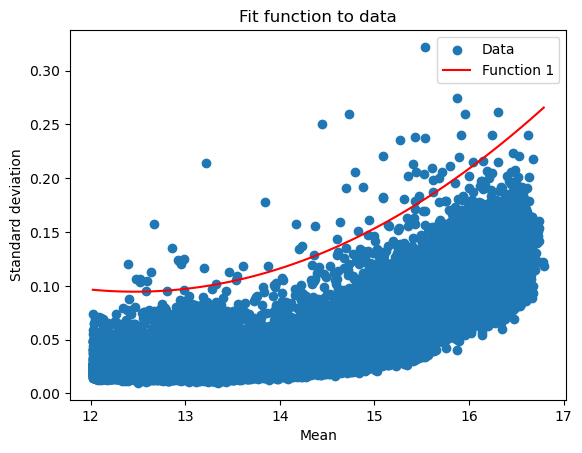

In [4]:
# Función para calcular el promedio excluyendo los NaN
def mean_without_nan(subarray):
    valid_values = [value for value in subarray if not np.isnan(value)]
    return np.mean(valid_values) if valid_values else np.nan

# Función para calcular la desviación estándar excluyendo los NaN
def std_without_nan(subarray):
    valid_values = [value for value in subarray if not np.isnan(value)]
    return np.std(valid_values) if valid_values else np.nan

# Calcula el promedio y la desviación estándar para cada subarray en ks_aleatorios
means = [mean_without_nan(subarray) for subarray in ks_aleatorios]
std_devs = [std_without_nan(subarray) for subarray in ks_aleatorios]

# Definir la función de ajuste
def funcion_ajuste(x, a, b, c):
    return a * x**2 + b * x + c  # Ejemplo de una función cuadrática
# Ajustar la función a los datos
popt, _ = curve_fit(funcion_ajuste, means, std_devs)
# Parámetros óptimos encontrados
a_opt, b_opt, c_opt = popt
# Imprimir la función de ajuste
print(f"Función de ajuste: {a_opt:.2f}x^2 + {b_opt:.2f}x + {c_opt:.2f}")

# Plotear los datos y la función de ajuste
plt.scatter(means, std_devs, label='Data')
x_range = np.linspace(min(means), max(means), 100)
plt.plot(x_range, funcion_ajuste(x_range, *popt+0.0004), color='red', label='Function 1')
plt.xlabel('Mean')
plt.ylabel('Standard deviation')
plt.title('Fit function to data')
plt.legend()
plt.show()

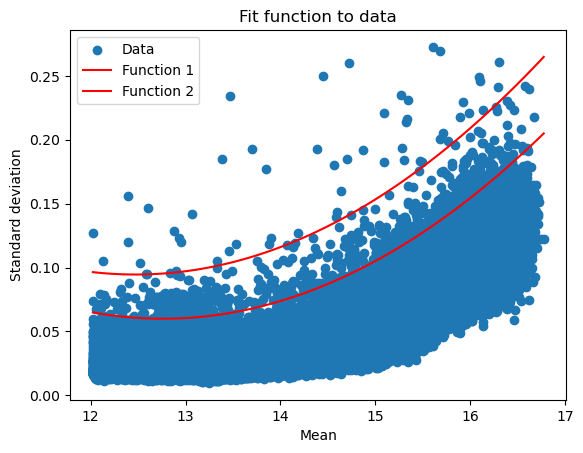

In [10]:
# Plotear los datos y la función de ajuste
plt.scatter(means, std_devs, label='Data')
x_range = np.linspace(min(means), max(means), 100)
plt.plot(x_range, funcion_ajuste(x_range, *popt+0.0004), color='red', label='Function 1')
plt.plot(x_range, funcion_ajuste(x_range, *popt+0.0002), color='red', label='Function 2')
plt.xlabel('Mean')
plt.ylabel('Standard deviation')
plt.title('Fit function to data')
plt.legend()
plt.show()

In [6]:
# Convertir means a un array de NumPy si no lo es
means = np.array(means)
# Calcular los valores predichos por la función ajustada para todos los elementos de means
predicciones = funcion_ajuste(means, *popt+0.0002)
# Encontrar las posiciones donde std_devs está por encima de las predicciones
posiciones_por_encima = np.where(std_devs > predicciones)[0]
# Imprimir las posiciones por encima del ajuste
print(len(posiciones_por_encima))

722


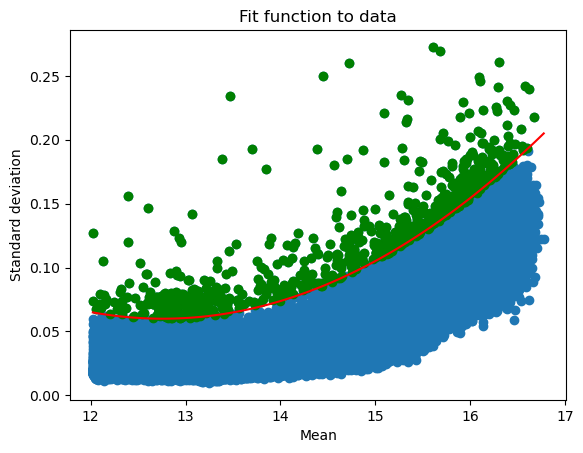

In [13]:
# Convertir means y std_devs a arrays de NumPy si no lo son
means = np.array(means)
std_devs = np.array(std_devs)

# Plotear los datos y la función de ajuste
plt.scatter(means, std_devs, label='Data')
x_range = np.linspace(min(means), max(means), 100)
plt.plot(x_range, funcion_ajuste(x_range, *popt+0.0002), color='red', label='Funtion')

# Plotear las posiciones por encima del ajuste cuadrático en otro color
plt.scatter(means[posiciones_por_encima], std_devs[posiciones_por_encima], color='green', label='Possible variables')
plt.xlabel('Mean')
plt.ylabel('Standard deviation')
plt.title('Fit function to data')
plt.show()

In [7]:
# Nuevo array para almacenar la información correspondiente a las posiciones sobre el ajuste
posibles_variables = []
pv_error=[]
# Iterar sobre las posiciones por encima del ajuste
for pos in posiciones_por_encima:
    posibles_variables.append(ks_aleatorios[pos])
    pv_error.append(errores_aleatorios[pos])
# Convertir la lista de subarrays a un array de NumPy
posibles_variables= np.array(posibles_variables)
pv_error=np.array(pv_error)
print(len(posibles_variables))
print(len(pv_error))

722
722


In [15]:
n2_archivo='PVariablesb2793.fits'
# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n2_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(posibles_variables, name='ks_PV')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {n2_archivo}")

# Abre el archivo FITS existente en modo de actualización ('update')
with fits.open(n2_archivo, mode='update') as hdul:
    # Crea un nuevo HDU con el nuevo array
    nuevo_hdu = fits.ImageHDU(pv_error, name='eks_PV')

    # Agrega el nuevo HDU al archivo FITS
    hdul.append(nuevo_hdu)

# Imprime un mensaje de confirmación
print(f"Nuevo HDU agregado al archivo FITS: {n2_archivo}")

Nuevo HDU agregado al archivo FITS: PVariablesb2793.fits
Nuevo HDU agregado al archivo FITS: PVariablesb2793.fits


In [8]:
def eliminar_nan(error, ks, HJD):
    indices_validos = ~np.isnan(ks)
    error_filtrado = [error[i] for i in range(len(ks)) if indices_validos[i]]
    ks_filtrado = [ks[i] for i in range(len(ks)) if indices_validos[i]]
    HJD_filtrado = [HJD[i] for i in range(len(ks)) if indices_validos[i]]
    return error_filtrado, ks_filtrado, np.round(HJD_filtrado,8)

ks_nan=[]
error_nan=[]
HJD_na=[]
y=0
while y<len(posibles_variables):
    error_filtrado, ks_filtrado, HJD_filtrado = eliminar_nan(pv_error[y], posibles_variables[y], HJD-2400000)
    ks_nan.append(ks_filtrado)
    error_nan.append(error_filtrado)
    HJD_na.append(HJD_filtrado)
    y+=1

    

x=0
while x<len(ks_nan):
    serie = ks_nan[x]
    erro = error_nan[x]
    hjd = HJD_na[x]

    # Definir el nombre del archivo de texto
    nombre_archivo = "F3b279"+str(x)+".txt"

    with open(nombre_archivo, "w") as archivo:
        for h, s, e in zip(hjd, serie, erro):
            archivo.write("{:<15} {:<10} {:<6}\n".format(h, s, e))
    x+=1
print("hecho")

hecho


In [9]:
y=0
freq=[]
powe=[]
peri=[]
nombre=[]
while y<len(ks_nan):
    S=ks_nan[y]
    Date=HJD_na[y]
    # Calcular el espectro de potencia utilizando Lomb-Scargle
    frequency, power = LombScargle(Date, S).autopower()
    # Encontrar picos en el espectro de potencia
    peaks, _ = find_peaks(power)
    # Obtener los 5 picos más significativos
    sorted_peaks = sorted(peaks, key=lambda x: power[x], reverse=True)[:5]
    frecuencia, potencia= frequency[sorted_peaks], list(power[sorted_peaks])
    max_p=max(potencia)
    r = potencia.index(max_p)
    f=frecuencia[r]
    P=1/f
    nombre.append("F3b279"+str(y)+".txt")
    freq.append(f)
    powe.append(max_p)
    peri.append(P)
    y+=1
    
# Ordenar las listas basadas en la lista powe
sorted_data = sorted(zip(powe, freq, peri, nombre), reverse=True)
# Desempaquetar las listas ordenadas
powe, freq, peri, nombre = zip(*sorted_data)
# Nombre del archivo de texto
nombre_archivo = "F3B279.txt"
# Guardar en archivo de texto
with open(nombre_archivo, "w") as archivo:
    for n in nombre:
        archivo.write(n + "\n") 
print("hecho")

hecho
